First, we will be performing colorization using https://github.com/richzhang/colorization.

In [49]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import torch
import os
import sys
from skimage.color import lab2rgb
sys.path.append('../artifacts')
from cwgan import *
from colorization.colorizers import *

In [3]:
bw_files = os.listdir("../data/test_black_white/")
og_files = os.listdir("../data/test_colored_normal/")
if not os.path.exists("../data/eccv_color"):
    os.mkdir("../data/eccv_color")
if not os.path.exists("../data/siggraph_color"):    
    os.mkdir("../data/siggraph_color")

In [5]:
# Load colorizers

colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()

In [ ]:
# Colorize images
for address in bw_files:
    # load images
    img = load_img(f"../data/test_black_white/{address}")
    # getting the l channel for original and reshaped images
    (tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256, 256))
    # colorizer outputs 256x256 ab map that is resized and concat to fit original l channel
    img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig, 0*tens_l_orig), dim=1))
    out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
    out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

    plt.imsave(f'../data/eccv_color/{address}', out_img_eccv16)
    plt.imsave(f'../data/siggraph_color/{address}', out_img_siggraph17)


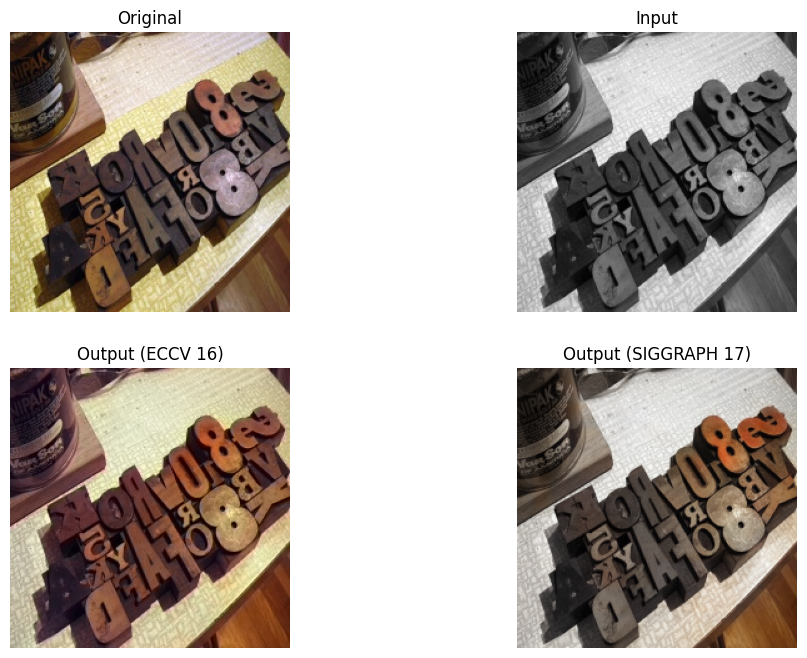

In [7]:
# load image
img = load_img("../data/test_colored_normal/colored_image_dataset_2_sample_0.jpg")
# getting the l channel for original and reshaped images
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256, 256))
# colorizer outputs 256x256 ab map that is resized and concat to fit original l channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig, 0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

plt.imsave('s_eccv16.png', out_img_eccv16)
plt.imsave('s_siggraph17.png', out_img_siggraph17)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(out_img_siggraph17)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

Now, we will perform it using re-trained CWGAN model.

In [8]:
if not os.path.exists("../data/wgan_colorized"):
    os.mkdir("../data/wgan_colorized")

In [24]:
cwgan_model = torch.load("../artifacts/cwgan")
cwgan_model.load_state_dict(torch.load("../artifacts/retrained_model.ckpt")["state_dict"])

<All keys matched successfully>

In [51]:
def lab_to_rgb(L, ab):
    """
    Takes an image or a batch of images and converts from LAB space to RGB
    """
    L = L  * 100
    ab = (ab - 0.5) * 128 * 2
    Lab = torch.cat([L, ab], dim=2).numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [61]:
from tqdm import tqdm

for i in tqdm(range(len(bw_files))):
    img = load_img(f"../data/test_black_white/{bw_files[i]}")
    tensor_img = torch.from_numpy(img).permute(2, 0, 1)[0, :, :].to(torch.float32)
    tensor_img = tensor_img.unsqueeze(0)
    tensor_img = tensor_img.unsqueeze(0)
    pred = cwgan_model.generator(tensor_img).detach().squeeze().permute(1, 2, 0)
    tensor_img  = tensor_img.detach().squeeze(0).permute(1, 2, 0)
    imgan = lab_to_rgb(tensor_img, pred)
    plt.imsave(f"../data/wgan_colorized/{bw_files[i]}", imgan)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [26:25<00:00,  3.15it/s]
